In [1]:
import sys
sys.path.insert(0,'..')
import scipy.io
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
import os.path
from pymanopt.manifolds import Sphere, Grassmann, ComplexGrassmann
from PGA import *
from compute_centroid import *
from grass_DR import *
from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import DistanceMetric
from scipy import stats
from PNG import *
from sklearn.decomposition import PCA
from Complex_PCA import *
import matplotlib.pyplot as plt
from shape_transform import *
import rpy2.robjects as robjects
import pandas as pd
from plotnine import *
from sPCA import SPCA
from sklearn import svm
from sklearn.metrics import accuracy_score

In [2]:
def plot_shape(s, markersize=1):
    # s is an 1-d array of complex numbers
    # plot s.real v.s s.imag
    if s.ndim == 2:
        plt.scatter(s.real, s.imag, s = markersize)
        plt.axis('off')
        plt.show()
    else:
        N = s.shape[0]
        w = np.int(np.sqrt(N))
        h = np.int(np.ceil(N/w))
        for i in range(N):
            plt.subplot(w,h,i+1)
            plt.scatter(s[i].real, s[i].imag, s = markersize)
            plt.axis('off')
        plt.show()

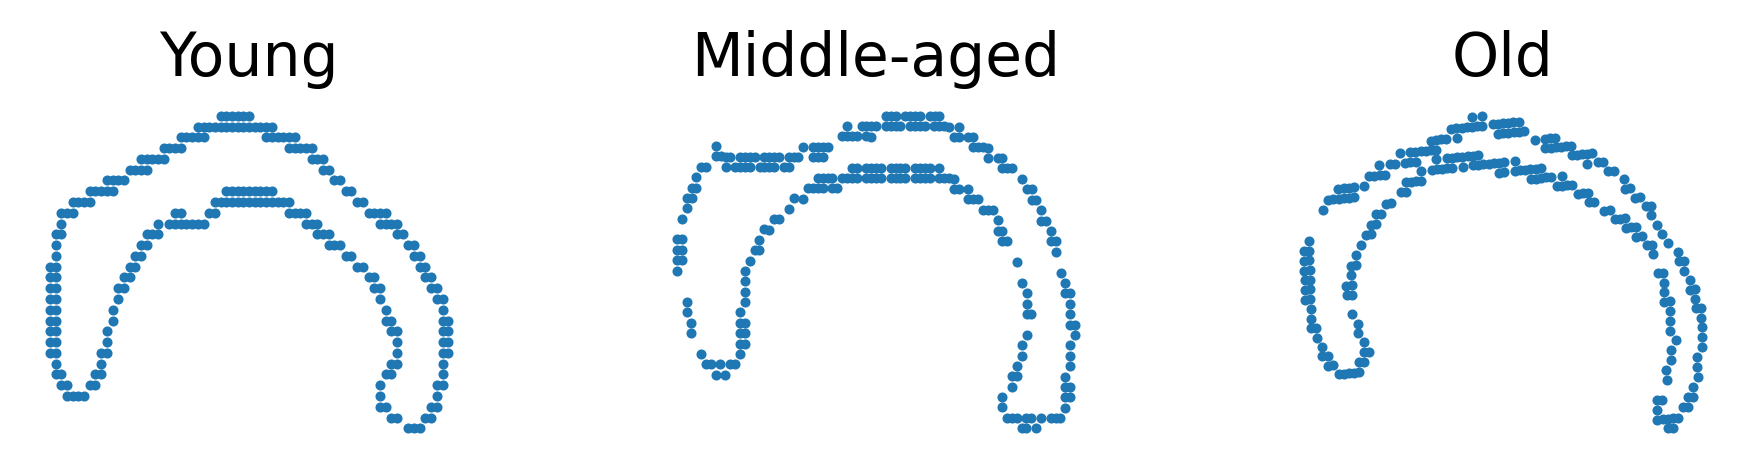

In [19]:
mat = scipy.io.loadmat('OASIS_kendall.mat')
X = mat['X'].transpose()
label = mat['label'].reshape(-1)
group = np.floor((label - 1)/3)

X_complex = X[:,0,:] + 1j*X[:,1,:]


fig = plt.figure(num=None, figsize=(6, 2), dpi=300, facecolor='w', edgecolor='k')

plt.rcParams.update({'font.size': 12})
plt.subplot(1,3,1)
plt.scatter(X_complex[label == 1][0].imag, X_complex[label == 1][0].real, s = 2)
plt.tight_layout()
plt.title('Young')
plt.axis('off')

plt.subplot(1,3,2)
plt.scatter(X_complex[label == 5][0].imag, X_complex[label == 5][0].real, s = 2)
plt.tight_layout()
plt.title('Middle-aged')
plt.axis('off')

plt.subplot(1,3,3)
plt.scatter(X_complex[label == 9][0].imag, X_complex[label == 9][0].real, s = 2)
plt.tight_layout()
plt.title('Old')
plt.axis('off')


plt.savefig('OASIS_CC_shape.pdf')
plt.show()

In [2]:
mat = scipy.io.loadmat('OASIS_kendall.mat')
X = mat['X'].transpose()
label = mat['label'].reshape(-1)
group = np.floor((label - 1)/3)
X = X.transpose((2,1,0))
X = shape_transform(X)
X.shape

(36, 249, 1)

In [5]:
X_low, _, _ = NG_dr(X, 36, verbosity = 1)

Terminated - max iterations reached after 605.93 seconds.



In [8]:
res = pd.DataFrame(columns=['method', 'component', 'var_ratio'])

## Principal Nested Grassmann

In [9]:
scores_PNG = PNG(X_low, verbosity = 1)

Gr(1, 36) -> Gr(1, 35)
Terminated - max iterations reached after 54.02 seconds.

Gr(1, 35) -> Gr(1, 34)
Terminated - max iterations reached after 50.90 seconds.

Gr(1, 34) -> Gr(1, 33)
Terminated - max iterations reached after 51.77 seconds.

Gr(1, 33) -> Gr(1, 32)
Terminated - max iterations reached after 52.10 seconds.

Gr(1, 32) -> Gr(1, 31)
Terminated - max iterations reached after 51.77 seconds.

Gr(1, 31) -> Gr(1, 30)
Terminated - max iterations reached after 57.88 seconds.

Gr(1, 30) -> Gr(1, 29)
Terminated - max iterations reached after 55.94 seconds.

Gr(1, 29) -> Gr(1, 28)
Terminated - max iterations reached after 56.29 seconds.

Gr(1, 28) -> Gr(1, 27)
Terminated - max iterations reached after 53.54 seconds.

Gr(1, 27) -> Gr(1, 26)
Terminated - max iterations reached after 52.54 seconds.

Gr(1, 26) -> Gr(1, 25)
Terminated - max iterations reached after 47.35 seconds.

Gr(1, 25) -> Gr(1, 24)
Terminated - max iterations reached after 48.43 seconds.

Gr(1, 24) -> Gr(1, 23)
Termi

In [11]:
n_c = 10
png = Complex_PCA(n_components = n_c)
png.fit(scores_PNG)
print(f'The ratios of expressed variance of the first {n_c} PCs.')
print(png.explained_variance_ratio_.round(2))
print(f'The cumulative ratios of expressed variance of the first {n_c} PCs.')
print(np.cumsum(png.explained_variance_ratio_).round(2))

for l in range(n_c):
    res = res.append({'method':'PNG',
                    'component':l+1, 
                    'var_ratio':np.cumsum(png.explained_variance_ratio_)[l]*100}, ignore_index = True)

The ratios of expressed variance of the first 10 PCs.
[0.61 0.16 0.08 0.05 0.02 0.02 0.01 0.01 0.01 0.01]
The cumulative ratios of expressed variance of the first 10 PCs.
[0.61 0.77 0.85 0.9  0.92 0.94 0.95 0.96 0.97 0.98]


## Principal Geodesic Analysis

In [13]:
N, n, p = X.shape
man = ComplexGrassmann(n, p)
cpga = Complex_PGA(X, n_c, man)
print(f'The ratios of expressed variance of the first {n_c} PCs.')
print(cpga.explained_variance_ratio_.round(2))
print(f'The cumulative ratios of expressed variance of the first {n_c} PCs.')
print(np.cumsum(cpga.explained_variance_ratio_).round(2))
# need transformed coordinate for visualization

for l in range(n_c):
    res = res.append({'method':'PGA',
                    'component':l+1, 
                    'var_ratio':np.cumsum(cpga.explained_variance_ratio_)[l]*100}, ignore_index = True)

The ratios of expressed variance of the first 10 PCs.
[0.09 0.07 0.07 0.07 0.06 0.05 0.05 0.04 0.04 0.04]
The cumulative ratios of expressed variance of the first 10 PCs.
[0.09 0.17 0.24 0.3  0.37 0.42 0.46 0.51 0.54 0.58]


## Principal Nested Shape Spaces

In [ ]:
pnss_ratio = robjects.r('''
                     library(shapes)
                     library(R.matlab)
                     mat <- readMat("OASIS_kendall.mat")
                     X <- mat$X
                     sink("/dev/null")
                     out <- pnss3d(X, n.pc = {})
                     sink()
                     out$percent   
                     '''.format(2*n_c))

R[write to console]: R.matlab v3.6.2 (2018-09-26) successfully loaded. See ?R.matlab for help.

R[write to console]: 
Attaching package: ‘R.matlab’


R[write to console]: The following objects are masked from ‘package:base’:

    getOption, isOpen




In [20]:
pnss_ratio = np.array(pnss_ratio)
print(f'The ratios of expressed variance of the first {2*n_c} PCs.')
print(pnss_ratio.round(2))
print(f'The cumulative ratios of expressed variance of the first {2*n_c} PCs.')
print(np.cumsum(pnss_ratio).round(2))

for l in range(n_c):
    res = res.append({'method':'PNSS',
                    'component':l+1, 
                    'var_ratio':np.cumsum(pnss_ratio)[np.arange(1, 2*n_c, 2)][l]}, ignore_index = True)

The ratios of expressed variance of the first 20 PCs.
[4.617e+01 8.140e+00 5.450e+00 4.120e+00 3.270e+00 2.380e+00 1.780e+00
 1.580e+00 1.360e+00 1.160e+00 1.010e+00 9.300e-01 8.600e-01 7.400e-01
 7.000e-01 6.300e-01 5.800e-01 5.300e-01 4.600e-01 4.000e-02]
The cumulative ratios of expressed variance of the first 20 PCs.
[46.17 54.31 59.76 63.87 67.15 69.52 71.3  72.88 74.24 75.4  76.41 77.33
 78.19 78.94 79.63 80.27 80.85 81.38 81.84 81.88]


In [26]:
np.save('OASIS_result.npy', {'v_ratio':res})

In [27]:
v_ratio = np.load('OASIS_result.npy', allow_pickle=True)
v_ratio = v_ratio.item()['v_ratio']

In [29]:
p = ggplot(v_ratio) + \
    aes(x = 'component', y = 'var_ratio', color = 'method') + \
    geom_line(aes(group = 'method'), size = 1) + \
    labs(y = 'Cum. Var. Ratio (%)', x = 'Principal Components', color = '') + \
    scale_color_manual(values = ['red', 'blue', 'green'])

ggsave(plot=p, filename='OASIS_result.png', width = 10, height = 10, units = 'cm', dpi = 320)

/opt/conda/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 10.0 x 10.0 cm image.
/opt/conda/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: OASIS_result.png


# Supervised Experiments

In [3]:
acc = pd.DataFrame(columns=['method', 'acc'])
d_complex = 3 # reduced (complex) dimension

## Supervised Principal Nested Grassmann 

In [4]:
X_low, _, _ = NG_dr(X, 18, verbosity = 1)

Terminated - max iterations reached after 700.28 seconds.



In [5]:
scores_SPNG = SPNG(X_low, group, log = False, verbosity = 0)

In [6]:
clf = svm.SVC(decision_function_shape='ovo')
clf.fit(np.hstack((scores_SPNG[:,0:d_complex].real, scores_SPNG[:,0:d_complex].imag)), group)
group_pred = clf.predict(np.hstack((scores_SPNG[:,0:d_complex].real, scores_SPNG[:,0:d_complex].imag)))
acc = acc.append({'method': 'SPNG', 'acc': accuracy_score(group, group_pred)}, ignore_index = True)

## PNG

In [7]:
scores_PNG = PNG(X_low, log = False, verbosity = 0)

In [8]:
scores_PNG.shape

(36, 17)

In [9]:
clf = svm.SVC(decision_function_shape='ovo')
clf.fit(np.hstack((scores_PNG[:,0:d_complex].real, scores_PNG[:,0:d_complex].imag)), group)
group_pred = clf.predict(np.hstack((scores_PNG[:,0:d_complex].real, scores_PNG[:,0:d_complex].imag)))
acc = acc.append({'method': 'PNG', 'acc': accuracy_score(group, group_pred)}, ignore_index = True)

## SPGA

In [10]:
N, n, p = X.shape
man = ComplexGrassmann(n, p)
_, X_trans_SPGA = sPGA_complex(X, group.reshape(-1, 1), d_complex, man)

In [11]:
clf = svm.SVC(decision_function_shape='ovo')
clf.fit(np.hstack((X_trans_SPGA[:,0:d_complex].real, X_trans_SPGA[:,0:d_complex].imag)), group)
group_pred = clf.predict(np.hstack((X_trans_SPGA[:,0:d_complex].real, X_trans_SPGA[:,0:d_complex].imag)))
acc = acc.append({'method': 'SPGA', 'acc': accuracy_score(group, group_pred)}, ignore_index = True)

## PGA

In [12]:
N, n, p = X.shape
man = ComplexGrassmann(n, p)
cpga, X_trans_PGA = Complex_PGA(X, d_complex, man)

In [13]:
clf = svm.SVC(decision_function_shape='ovo')
clf.fit(np.hstack((X_trans_PGA.real, X_trans_PGA.imag)), group)
group_pred = clf.predict(np.hstack((X_trans_PGA.real, X_trans_PGA.imag)))
acc = acc.append({'method': 'PGA', 'acc': accuracy_score(group, group_pred)}, ignore_index = True)

## PNSS

In [14]:
scores_PNSS = robjects.r('''
                     library(shapes)
                     library(R.matlab)
                     mat <- readMat("OASIS_kendall.mat")
                     X <- mat$X
                     k <- dim(X)[1]
                     m <- dim(X)[2]
                     n <- dim(X)[3]
                     sink("/dev/null")
                     out <- pnss3d(X, n.pc = {})
                     sink()
                     out$GPAout$stdscores[1:n,]  
                     '''.format(2*d_complex))

R[write to console]: R.matlab v3.6.2 (2018-09-26) successfully loaded. See ?R.matlab for help.

R[write to console]: 
Attaching package: ‘R.matlab’


R[write to console]: The following objects are masked from ‘package:base’:

    getOption, isOpen




In [15]:
scores_PNSS = np.array(scores_PNSS)

In [16]:
clf = svm.SVC(decision_function_shape='ovo')
clf.fit(scores_PNSS[:,0:2*d_complex], group)
group_pred = clf.predict(scores_PNSS[:,0:2*d_complex])
acc = acc.append({'method': 'PNSS', 'acc': accuracy_score(group, group_pred)}, ignore_index = True)

## Result

In [17]:
acc

,method,acc
0,SPNG,0.833333
1,PNG,0.750000
2,SPGA,0.666667
3,PGA,0.638889
4,PNSS,0.805556


In [18]:
np.save('classification_result.npy',{'scores_PNSS': scores_PNSS,
                                    'scores_PGA': X_trans_PGA, 
                                    'scores_SPGA': X_trans_SPGA,
                                    'scores_PNG': scores_PNG,
                                    'scores_SPNG': scores_SPNG,
                                    'acc': acc})